### Logistic Regression with a Neural Network mindset
Welcome to your first (required) programming assignment! 

You will build a logistic regression classifier to recognize cats. 

This assignment will step you through how to do this with a Neural Network mindset, and will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.
- Use np.dot(X,Y) to calculate dot products.

- You will learn to:
    - Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent)
    - Gather all three functions above into a main model function, in the right order.
    
***Table of Contents***
- 1 - Packages
- 2 - Overview of the Problem set
    - Exercise 1
    - Exercise 2
- 3 - General Architecture of the learning algorithm
- 4 - Building the parts of our algorithm
    - 4.1 - Helper functions
        - Exercise 3 - sigmoid
    - 4.2 - Initializing parameters
        - Exercise 4 - initialize_with_zeros
    - 4.3 - Forward and Backward propagation
        - Exercise 5 - propagate
    - 4.4 - Optimization
        - Exercise 6 - optimize
        - Exercise 7 - predict
- 5 - Merge all functions into a model
    - Exercise 8 - model
- 6 - Further analysis (optional/ungraded exercise)
- 7 - Test with your own image (optional/ungraded exercise)

### 1 - Packages
First, let's run the cell below to import all the packages that you will need during this assignment.

- numpy is the fundamental package for scientific computing with Python.
- h5py is a common package to interact with a dataset that is stored on an H5 file.
- matplotlib is a famous library to plot graphs in Python.
- PIL and scipy are used here to test your model with your own picture at the end.

In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import scipy
from scipy import ndimage
import copy

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2 - Overview of the Problem set
Problem Statement: You are given a dataset ("data.h5") containing: 
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0) 
- a test set of m_test images labeled as cat or non-cat 
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [101]:
import pandas as pd
def load_data():
    train_data = h5py.File("./data/train_catvnoncat.h5", "r") #returns file object
    test_data = h5py.File("./data/test_catvnoncat.h5", "r")
    print(f"keys: {list(train_data.keys())}")
    print("Train data training set shape" + str(train_data["train_set_x"].shape)) #(209, 64, 64, 3) = 209 images, each image is of 3 channels with 64 pixels of height and width
    
    #Training set
    train_set_x_orig = np.array(train_data["train_set_x"][:])
    print(train_set_x_orig.shape) #(209, 64, 64, 3)
    train_set_y_orig = np.array(train_data["train_set_y"][:])
    print(train_set_y_orig.shape) #(209,)
    train_set_y_orig = train_set_y_orig.reshape(1, train_set_y_orig.shape[0]) #(1, 209)
    print(train_set_y_orig.shape)
    
    #Test set
    test_set_x_orig = np.array(test_data["test_set_x"][:])
    print(test_set_x_orig.shape) #(50, 64, 64, 3)
    test_set_y_orig = np.array(test_data["test_set_y"][:])
    print(test_set_y_orig.shape) #(50,)
    test_set_y_orig = test_set_y_orig.reshape(1, test_set_y_orig.shape[0]) #(1, 50)
    print(test_set_y_orig.shape)
    
    #class labels
    classes = np.array(train_data["list_classes"][:])
    print(classes)
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [103]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_data()

keys: ['list_classes', 'train_set_x', 'train_set_y']
Train data training set shape(209, 64, 64, 3)
(209, 64, 64, 3)
(209,)
(1, 209)
(50, 64, 64, 3)
(50,)
(1, 50)
[b'non-cat' b'cat']


In [207]:
#some explanation on 3d matrices
a = np.array([[1, 2, 3, 4]]) # row vector
print(a.shape)
print(a[:, 2]) #for all the existing rows, give the second column element
print(a[0][:]) #0th row, all column values
print(a[0, 2]) #that is 0th row
# print(a[1, 2]) #throws index out of bounds error as we have only one row whose index is 0 not 1. 
#Be aware you should access row or column vector as above

b = np.array([[1, 2, 3],
             [4, 5, 6]])
print(b.shape) #2 rows, 3 columns, 2d array

c = np.array([[1, 2], [3, 4],
             [5, 6], [7, 8]])
print(c.shape)

d = np.array([[[1, 2, 3]]]) #this represents single pixel of 1st row, 1st column ,if you think in image perspective. 
print(d.shape) #(1, 1, 3) - one row, one column, 3 channels

e = np.array([
    [[1, 2, 3], [3, 4, 5], [6, 7, 8], [9, 10, 11]]
]) #imagine each box [1, 2, 3] as single pixel for understanding, but in reality they are 3 pixels of all the 3 channels representing as a single pixel
print(e.shape) #(1, 4, 3) 1 row 4 column 3 channels


f = np.array([
    [[1, 2, 3], [3, 4, 5], [6, 7, 8], [9, 10, 11]],
    [[11, 12, 13], [13, 14, 15], [16, 17, 18], [19, 10, 11]],
]) 
print(f.shape) #(2, 4, 3) 2 rows, 4 columns, 3 channels

(1, 4)
[3]
[1 2 3 4]
3
(2, 3)
(4, 2)
(1, 1, 3)
(1, 4, 3)
(2, 4, 3)


In [97]:
first_img = train_set_x_orig[0]
print(first_img.shape) #show the first image. We ll get a 3d array(height, width, channels) which represents a single image
# print(first_img) #64 rows, 64 columns, 3 channels, [0, 0] of this gives pixel at location of 0th row 0th col, but we get 3 pixels of each channel instead of one pixel
print(first_img[0, 0]) #accessing first pixel at row 0 column 0 , imagine it as grid #think each pixel is a row with 3 values in it(3 pixels stacked next to each other)
print(first_img[0].shape) #accessing first row having 64 columns and 3 pixels
print(first_img[0])  #1st row with 64 columns contains pixels each of 3 rgb channels

(64, 64, 3)
[17 31 56]
(64, 3)
[[17 31 56]
 [22 33 59]
 [25 35 62]
 [25 35 62]
 [27 36 64]
 [28 38 67]
 [30 41 69]
 [31 43 73]
 [32 47 76]
 [34 49 79]
 [35 50 82]
 [36 51 82]
 [35 50 81]
 [34 49 79]
 [33 48 79]
 [33 48 79]
 [32 47 78]
 [31 46 76]
 [30 44 75]
 [29 44 75]
 [29 44 75]
 [27 44 74]
 [27 42 73]
 [25 41 71]
 [23 40 72]
 [21 41 73]
 [21 42 74]
 [21 41 74]
 [20 40 73]
 [20 39 72]
 [19 39 72]
 [18 38 71]
 [16 38 70]
 [14 37 69]
 [12 37 68]
 [11 36 67]
 [ 9 36 66]
 [ 7 34 64]
 [ 7 35 66]
 [ 4 36 69]
 [ 3 36 69]
 [ 2 34 65]
 [ 2 34 65]
 [ 1 35 67]
 [ 1 34 67]
 [ 1 34 66]
 [ 0 32 63]
 [ 1 30 61]
 [ 1 30 62]
 [ 2 29 59]
 [ 0 29 59]
 [ 1 29 59]
 [ 1 28 58]
 [ 1 28 57]
 [ 1 28 57]
 [ 1 28 57]
 [ 1 28 57]
 [ 1 25 55]
 [ 0 25 55]
 [ 1 27 58]
 [ 1 28 58]
 [ 1 28 57]
 [ 1 26 56]
 [ 1 22 51]]


    The resulting array will always have this order: (H, W, D) i.e. (height, width, depth) because of the terminology that numpy uses for ndarrays (axis=0, axis=1, axis=2) or analogously (Y, X, Z) if one would like to visualize in 3 dimensions.

    We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

    Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the index value and re-run to see other images.

y = [1], and it's a cat picture


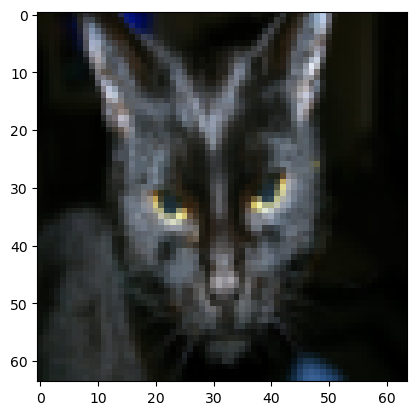

In [104]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[25])
print("y = " + str(train_set_y_orig[:, index]) + ", and it's a " + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + " picture")
plt.show()

    Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

##### Exercise 1
    Find the values for: - m_train (number of training examples) - m_test (number of test examples) - num_px (= height = width of a training image) Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access m_train by writing train_set_x_orig.shape[0].

In [105]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


    For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px * num_px * 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.


#### Exercise 2
    Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px * num_px *3, 1).

    A trick when you want to flatten a matrix X of shape (a, b, c, d) to a matrix X_flatten of shape (b * c* d, a) is to use:

            X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

**Why the reshape train_set_x_orig.reshape(m_train, -1).T and transpose instead of direct reshapetrain_set_x_orig.reshape(-1, m_train)?**


    Citation: This is taken from DeepLearning.ai Discourse platform, answered by PaulinPaloalto

    The input data for the Course 1 Week 2 Logistic Regression assignment consists of 64 x 64 RGB images with corresponding labels for whether the images contain a cat or not.
    
    There are 209 training images and 50 test images.

    So that means that the input images for training are given to us as a 4 dimensional numpy array with the shape:

                                        209 x 64 x 64 x 3

    The first dimension is the “samples” dimension. For each of the 209 samples there are 64 x 64 pixels and each pixel has 3 color values R, G and B. 

                                    Note that:   64 x 64 x 3 = 12288

    In order to process these images with either Logistic Regression or a Neural Network, we first need to “unroll” or “flatten” each image into a column vector.

    That is because we represent the input vectors as column vectors. That means that we will end up with the training data as a 12288 x 209 matrix in which each column is one flattened image. 

    So how do we convert the given 4 dimensional array into that 2 dimensional matrix? They give us the following python statement to do the flatten operation:

                                        X_flatten = X.reshape(X.shape[0], -1).T

    Note that the -1 there is not anything magic: it is just a shortcut that means “use all the leftover values of the remaining dimensions here”. 

                        You could get the same result with this statement:

                X_flatten = X.reshape(X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]).T

    The really important point here is the transpose, not the -1. The point is that the first dimension is the “samples” dimension and that dimension must be preserved in the output.

    Without the transpose, we will end up with a 209 x 12288 matrix with the samples as the rows and the transpose gives us 12288 x 209 with the samples as the columns. 

    Now you might think that an easier way to get a 12288 x 209 matrix would be to do the “reshape” this way:

                                X_flatten = X.reshape(-1, X.shape[0])

    That does give you the same output shape, but it turns out that the results are garbage.
    
    That method “scrambles” the data by mixing pixels from multiple images into each column of the output. To see why, let’s construct a simpler example that will let us visualize what is happening. Open a new cell and enter the following function:

In [6]:
# routine to generate a telltale 4D array to play with
import numpy as np
def testarray(shape):
    (d1, d2, d3, d4) = shape
    A = np.zeros(shape)

    for ii1 in range(d1):
        for ii2 in range(d2):
            for ii3 in range(d3):
                for ii4 in range(d4):
                    A[ii1, ii2, ii3, ii4] = ii1 * 1000 + ii2 * 100 + ii3 * 10 + ii4 
    return A

    What that does is create a 4D array where the value in each position of the array shows the index values of its position in the array with each dimension in order. 
    
            That is to say A[1, 2, 3, 4] = 1234.
            
     Of course this is only going to be understandable if all the dimensions are single digit size. Using that function, we can create a play 4D array of dimensions 3 x 2 x 2 x 3 (which you can think of as 3 samples, each of which is a 2 x 2 RGB image) and then unroll it in both ways:

In [114]:
#generating q 4d array
A = testarray((3, 2, 2, 3)) #3 samples, each sample contains 2 rows, 2 feature and each pixel is of 3 channels

#using transpose
Ashape1 = A.reshape(A.shape[0], -1).T

#without transpose
Ashape2 = A.reshape(-1, A.shape[0])

np.set_printoptions(suppress=True)
print("A.shape = " + str(A.shape))
print(A)

print("\nAshape1.shape wih transpose= " + str(Ashape1.shape) +"\n")
print(Ashape1)

print("\nAshape2.shape without transpose= " + str(Ashape2.shape) +"\n")
print(Ashape2)

A.shape = (3, 2, 2, 3)
[[[[   0.    1.    2.]
   [  10.   11.   12.]]

  [[ 100.  101.  102.]
   [ 110.  111.  112.]]]


 [[[1000. 1001. 1002.]
   [1010. 1011. 1012.]]

  [[1100. 1101. 1102.]
   [1110. 1111. 1112.]]]


 [[[2000. 2001. 2002.]
   [2010. 2011. 2012.]]

  [[2100. 2101. 2102.]
   [2110. 2111. 2112.]]]]

Ashape1.shape wih transpose= (12, 3)

[[   0. 1000. 2000.]
 [   1. 1001. 2001.]
 [   2. 1002. 2002.]
 [  10. 1010. 2010.]
 [  11. 1011. 2011.]
 [  12. 1012. 2012.]
 [ 100. 1100. 2100.]
 [ 101. 1101. 2101.]
 [ 102. 1102. 2102.]
 [ 110. 1110. 2110.]
 [ 111. 1111. 2111.]
 [ 112. 1112. 2112.]]

Ashape2.shape without transpose= (12, 3)

[[   0.    1.    2.]
 [  10.   11.   12.]
 [ 100.  101.  102.]
 [ 110.  111.  112.]
 [1000. 1001. 1002.]
 [1010. 1011. 1012.]
 [1100. 1101. 1102.]
 [1110. 1111. 1112.]
 [2000. 2001. 2002.]
 [2010. 2011. 2012.]
 [2100. 2101. 2102.]
 [2110. 2111. 2112.]]


    After you run the above cell, observe the output

    Notice how each column of Ashape1 has consistent values for the first dimension, whereas that is not true for Ashape2 . 
    
    You can see that each column of Ashape2 contains entries from all three of the input samples (values of the first index of the input i.e first image). Also if you read down the columns in Ashape1, you can see that the unrolling happens from the highest dimension (Color dimension(3)) backwards. That is the color dimension, so that means that the order is all 3 color values at each position/pixel together and then it steps through the width and height dimensions.

    This demonstrates why the second method actually scrambles the data, making it meaningless for our purposes. That is why you get 34% test accuracy if you run the training using the incorrectly flattened data: the images no longer make any sense.

In [115]:
A = testarray((3, 2, 2, 3))
Ashape1 = A.reshape(A.shape[0], -1)

np.set_printoptions(suppress=True)
print("Ashape1.shape = " + str(Ashape1.shape))
print(Ashape1)

Ashape1.shape = (3, 12)
[[   0.    1.    2.   10.   11.   12.  100.  101.  102.  110.  111.  112.]
 [1000. 1001. 1002. 1010. 1011. 1012. 1100. 1101. 1102. 1110. 1111. 1112.]
 [2000. 2001. 2002. 2010. 2011. 2012. 2100. 2101. 2102. 2110. 2111. 2112.]]


    So you can see that you get exactly what you’d expect from the transpose that showed in the above original example.

    The unrolling done by reshape happens from the highest dimension first. That is demonstrated by the two examples I gave. Notice that it’s easier to see what is happening without the transpose: it just starts at (0, 0) and unrolls across the first row and it turns out it hits the end of the first row at just the right time because we set the dimensions correctly.

    Unrolling from the highest dimension first is just the default behavior of reshape. You can use the “order” parameter to specify a different arrangement. Watch this:

In [12]:
Ashape2 = A.reshape(A.shape[0], -1, order='F')
#this essentailly unrolls channel after channel for all rows unlike the above example
print("Ashape2.shape = " + str(Ashape2.shape))
print(Ashape2)
Ashape2.shape = (3, 12)

Ashape2.shape = (3, 12)
[[   0.  100.   10.  110.    1.  101.   11.  111.    2.  102.   12.  112.]
 [1000. 1100. 1010. 1110. 1001. 1101. 1011. 1111. 1002. 1102. 1012. 1112.]
 [2000. 2100. 2010. 2110. 2001. 2101. 2011. 2111. 2002. 2102. 2012. 2112.]]


    Notice that if you take the transpose of that matrix, it will still have the property that each column has a consistent first dimension value (0 for the first column, 1 for the second and so forth). That means that the data is not “scrambled”. It’s just a different way to order the pixels in each image. It turns out that you can run the experiment of using “F” order instead of the default “C” order and the training works exactly as well as it does with “C”. As long as you do the reshapes all(test and training) in the same consistent way, the algorithm can learn to recognize the patterns.

    The way to think about the difference between “C” and “F” order for an image is to remember that the highest dimension is the RGB color dimension. So what that means is that with “C” order you get all three colors for each pixel together. With “F” order, what you get is all the Red pixel values in order across and down the image, followed by all the Green pixels, followed by all the Blue pixels. So it’s like three separate monochrome images back to back. It’s worth trying the experiment of using “F” order on all your reshapes and then running the training and confirming that you get the same accuracy results. In other words, the algorithm can learn the patterns either way. It just matters that you are consistent in how you do the unrolling. You can even do the “negative” experiment to confirm the science here: unroll the training images in “F” order and the test images in “C” order and confirm that you get terrible test accuracy. Science! 
    
    
    Side note: 
    Each of element in (64x64) is a array [R,G,B]
    The pixel color values are supplied by the last “channel” dimension. 
    For each of the 64 x 64 pixel positions we have three 8 bit unsigned integer values for the R, G and B color intensity values which are the 3 channels. 
    We don’t have to “determine” these: they are given to us. They are produced by the camera that digitized the image. 
    Note that there are lots of different image formats and not all of them use RGB, but it is one of the common image representations. 
    If you want to know more about how image encoding works, try googling something like “what is a JPEG image”.
    Yes, the point is that everything our algorithms can do is based on analyzing the color values of the pixels in order to learn to recognize things like primitive shapes e.g. edges and curves and then putting those together to recognize more complex structures like a cat’s ear or tail.

In [117]:
#Now reshaping our original data for all the training examples to be of shape (nx, m)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


# Check that the first 10 pixels of the second image are in the correct place
assert np.alltrue(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]),  "Wrong solution. Check the flattened train array"
assert np.alltrue(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]), "Wrong solution. Check the flattened test array"

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


    As we already know, to represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

    One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you subtract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

    Let's standardize our dataset.

In [209]:
#standardize
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

#### What you need to remember:

    Common steps for pre-processing a new dataset are:

       - Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
       - Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
       - "Standardize" the data

### 3 - General Architecture of the learning algorithm
    It's time to design a simple algorithm to distinguish cat images from non-cat images.

    You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why Logistic Regression is actually a very simple Neural Network!
    
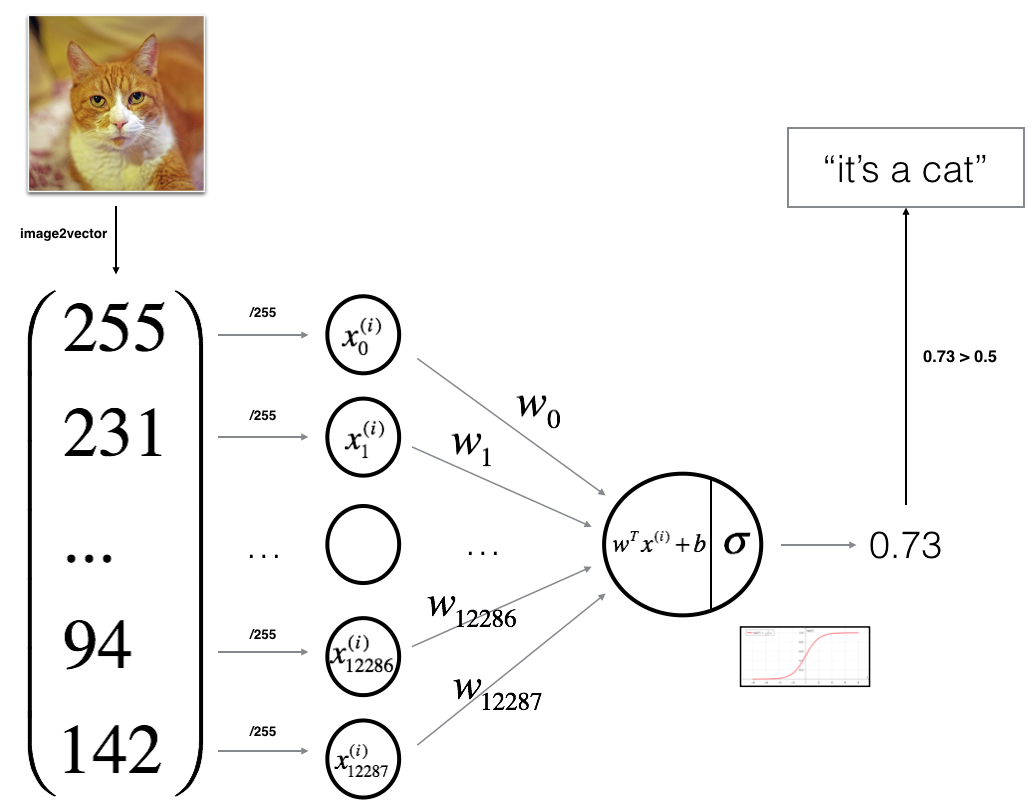


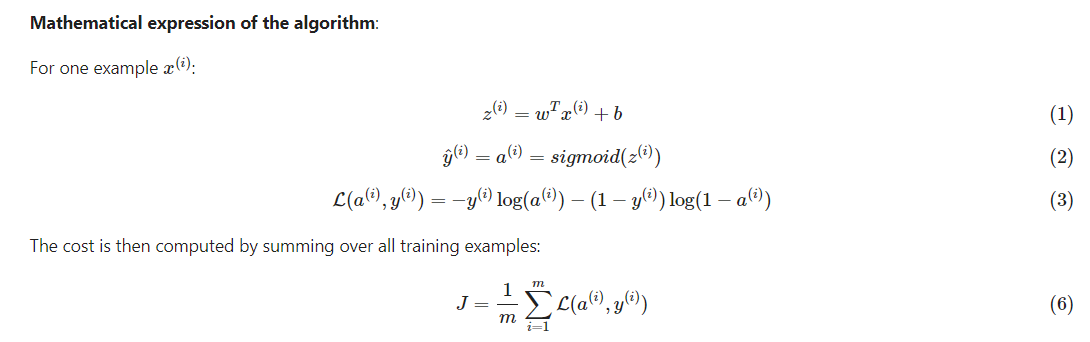 

**Key steps: In this exercise, you will carry out the following steps:**

- Initialize the parameters of the model 
- Learn the parameters for the model by minimizing the cost
- Use the learned parameters to make predictions (on the test set) - Analyse the results and conclude


#### 4 - Building the parts of our algorithm
    The main steps for building a Neural Network are:

        1. Define the model structure (such as number of input features)
        2. Initialize the model's parameters
        3. Loop:
            Calculate current loss (forward propagation)
            Calculate current gradient (backward propagation)
            Update parameters (gradient descent)
        
        You often build 1-3 separately and integrate them into one function we call model().


##### 4.1 - Helper functions

##### Exercise 3 - sigmoid
    Using your code from "Python Basics", implement sigmoid(). As you've seen in the figure above, you need to compute sigmoid(z) = 1 / 1 + e^-z where z = w.Tx + b to make predictions. Use np.exp()

In [120]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1.0 / (1.0 + np.exp(-z))
    return s

In [122]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0, 2])))) # sending 2 sendin z values, returns element wise sigmoid

sigmoid([0, 2]) = [0.5        0.88079708]


In [123]:
x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


#### 4.2 - Initializing parameters

##### Exercise 4 - initialize_with_zeros
    Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [125]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((dim, 1))
    b = 0.0
    return w, b

In [126]:
#testing
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


#### 4.3 - Forward and Backward propagation
    Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

#### Exercise 5 - propagate
    Implement a function propagate() that computes the cost function and its gradient.

    Forward Propagation:
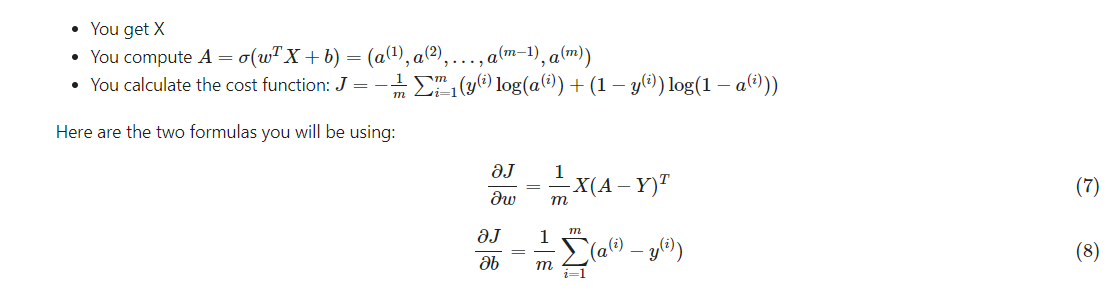

##### Look into C1W2Lecture "Explanation of Logistic Regression Cost Function (Optional)" to understand the derivation/justification of logistic loss function using probability, MLE, iid

In [138]:
def propagate(w, b, X, y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    m = X.shape[1]
    
    #forward propagation
    z = np.dot(w.T, X) + b                 #(1, 209)
    a = sigmoid(z)                         #(1, 209)
    
    #Cost
    J = - np.sum(y * np.log(a) + (1 - y) * np.log(1 - a)) / m   #cost function (loss of all the examples) = scalar 
    cost = np.squeeze(np.array(J)) #np.squeeze([0.15900537707692405])
#     print(f"J: {J}") #0.15900537707692405
#     print(f"cost: {cost}") ##0.15900537707692405
    
    #gradients
    dJ_dw = (np.dot(X, (a - y).T)) / m # (12288, 209) (1, 209) = (12288, 1)
    dJ_db = (np.sum(a - y)) / m # scalar
    
    grads = {
        "dw" : dJ_dw,
        "db" : dJ_db
    }
    return grads, cost

In [144]:
w =  np.array([[1.], [2]])
b = 1.5
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.12500404500439652
cost = 0.15900537707692405


#### 4.4 - Optimization
    You have initialized your parameters.
    You are also able to compute a cost function and its gradient.
    Now, you want to update the parameters using gradient descent.

#### Exercise 6 - optimize
    Write down the optimization function. The goal is to learn w and b by minimizing the cost function J. For a parameter θ, the update rule is θ = θ - α dw, where α is the learning rate.

In [156]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs = []
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        
        #optimize
        w -= learning_rate * dw
        b -= learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
            
            if print_cost:
                print(f"Iteration {i}, Cost: {cost}")
                
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

In [157]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]


#### Exercise 7 - predict
    The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function. There are two steps to computing predictions:

     1. Calculate Yhat = A = sigmoid(w.T X + b)
    2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. 
    
    If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [267]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    Y_a = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(Y_a.shape[1]):
        if Y_a[0, i] > 0.5:
             Y_prediction[0, i] = 1
        else:
             Y_prediction[0, i] = 0

#     Y_prediction = (Y_a > 0.5).astype(int)
    return Y_prediction 

In [160]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


#### What to remember:

    You've implemented several functions that:

        - Initialize (w, b)
        - Optimize the loss iteratively to learn parameters (w, b):
            - Computing the cost and its gradient
            - Updating the parameters using gradient descent
        - Use the learned (w, b) to predict the labels for a given set of examples

#### 5 - Merge all functions into a model
    You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

#### Exercise 8 - model
    Implement the model function. 
    Use the following notation: 
        - Y_prediction_test for your predictions on the test set 
        - Y_prediction_train for your predictions on the train set 
        - parameters, grads, costs for the outputs of optimize()

In [268]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    n, m = X_train.shape
#     print(n)
    w, b = initialize_with_zeros(n) #eg, X = (12288, 209) w =(12288, 1), b=scalar
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost=print_cost)
    w, b = params["w"], params["b"]
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_train - Y_prediction_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_test - Y_prediction_test)) * 100))
        
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

In [269]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Iteration 0, Cost: 0.6931471805599453
Iteration 100, Cost: 0.5845083636993086
Iteration 200, Cost: 0.46694904094655476
Iteration 300, Cost: 0.3760068669480209
Iteration 400, Cost: 0.33146328932825125
Iteration 500, Cost: 0.303273067474383
Iteration 600, Cost: 0.27987958658260487
Iteration 700, Cost: 0.2600421369258757
Iteration 800, Cost: 0.2429406846779662
Iteration 900, Cost: 0.2280042225672607
Iteration 1000, Cost: 0.21481951378449643
Iteration 1100, Cost: 0.20307819060644985
Iteration 1200, Cost: 0.19254427716706862
Iteration 1300, Cost: 0.18303333796883509
Iteration 1400, Cost: 0.17439859438448874
Iteration 1500, Cost: 0.1665213970540033
Iteration 1600, Cost: 0.15930451829756614
Iteration 1700, Cost: 0.15266732471296504
Iteration 1800, Cost: 0.14654223503982336
Iteration 1900, Cost: 0.1408720757031016
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


    Comment: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test accuracy is 70%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

    Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the index variable) you can look at predictions on pictures of the test set.

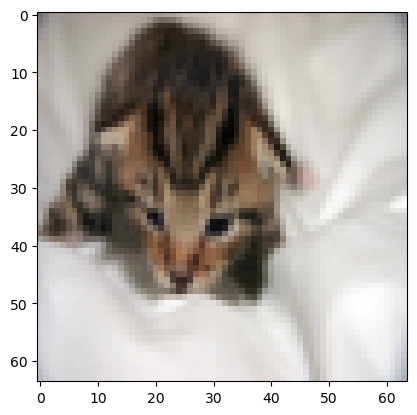

y = 1, Logistic regression predicted it as cat


In [270]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:, index].reshape(num_px, num_px, 3))
plt.show()
print("y = " + str(test_set_y[0, index]) + ", Logistic regression predicted it as " + classes[int(logistic_regression_model["Y_prediction_test"][:, index])].decode("utf-8"))

    Let's also plot the cost function and the gradients.

In [271]:
print(logistic_regression_model['costs'])

[array(0.69314718), array(0.58450836), array(0.46694904), array(0.37600687), array(0.33146329), array(0.30327307), array(0.27987959), array(0.26004214), array(0.24294068), array(0.22800422), array(0.21481951), array(0.20307819), array(0.19254428), array(0.18303334), array(0.17439859), array(0.1665214), array(0.15930452), array(0.15266732), array(0.14654224), array(0.14087208)]


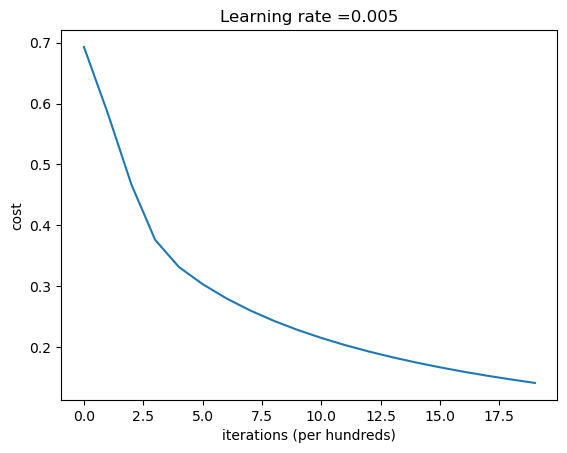

In [272]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

#### Interpretation:
    You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting.


#### 6 - Further analysis (optional/ungraded exercise)
    Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate α.

    Choice of learning rate
    ------------------------
    Reminder: In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate α determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

    Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the learning_rates variable to contain, and see what happens.

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------

[array(0.69314718), array(0.82392087), array(0.4189445), array(0.6173497), array(0.52211577), array(0.38770875), array(0.23625446), array(0.15422213), array(0.13532783), array(0.12497148), array(0.11647833), array(0.10919251), array(0.10280446), array(0.09712981), array(0.09204327), array(0.08745252), array(0.08328603), array(0.07948657), array(0.07600735), array(0.07280949)]
[array(0.69314718), array(0.59128943), array(0.55579611), array(0.52897651), array(0.50688129), array(0.48787986), array(0.47110828), array(0.45604581), array(0.44235023), array(0.42978172), array(0.41816382), array(0.40736175), array(0.39726947), array(0.38780161), array(0.37888813), array(0.37047069), array(0.36250

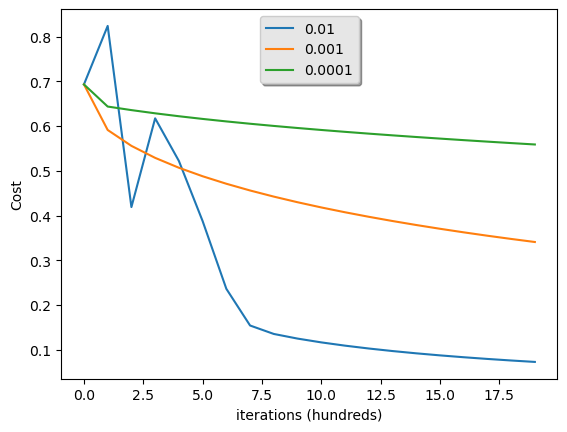

In [273]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=lr, print_cost=False)
    print ("\n" + "-------------------------------------------------------" + "\n")
    
for lr in learning_rates:
    print(models[str(lr)]["costs"])
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=models[str(lr)]["learning_rate"])
legend = plt.legend(loc="upper center", shadow=True)
frame = legend.get_frame()
frame.set_facecolor("0.90")
plt.xlabel("iterations (hundreds)") 
plt.ylabel("Cost") #note that y label will be the one we are plotting in plot
plt.show()

#### Interpretation:

    Different learning rates give different costs and thus different predictions results.
    
    If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost).
    
    A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.

    In deep learning, we usually recommend that you:
        Choose the learning rate that better minimizes the cost function.

    If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.)

#### 7 - Test with your own image (optional/ungraded exercise)
    Congratulations on finishing this assignment. You can use your own image and see the output of your model. 
    
    To do that: 
    
    Load your new image using PIL Image library and run the code and check if the algorithm is right (1 = cat, 0 = non-cat)

[[1.]]
1.0
y = 1.0, your algorithm predicts a "cat"


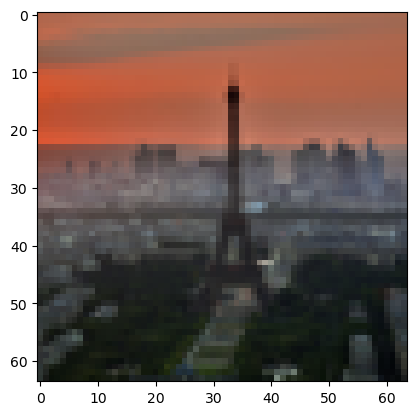

In [276]:
# change this to the name of your image file
my_image = "towerimage.jpg"   

# We preprocess the image to fit your algorithm.
fname = "./images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image.reshape((1, num_px * num_px * 3)).T
image = image / 255.
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)
print(my_predicted_image)
print((np.squeeze(my_predicted_image)))
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\"")

(64, 64, 3)


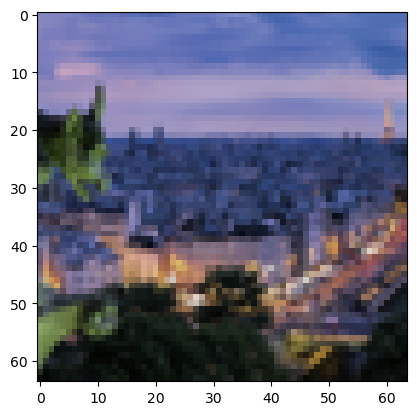

y = 0.0, and your algorithm predicts it as "cat"


In [228]:
myimage = "./images/gargouille.jpg"

# We preprocess the image to fit your algorithm.
image = np.array(Image.open(myimage).resize((num_px, num_px))) #converting image to an array after opening and resizing it
print(image.shape)
plt.imshow(image)
plt.show()

#normalize
image = image / 255

#reshape the image to a column vector using transpose
image = image.reshape(1, -1).T #1, image.shape[0] * image.shape[1] * image.shape[2]

#predict using our first model
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)
# print(classes[int(np.squeeze(my_predicted_image))]) #b'cat'
print("y = 0.0" + ", and your algorithm predicts it as \"" + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\"")

#Observe that model is predicting this gargoyle image as cat

(64, 64, 3)


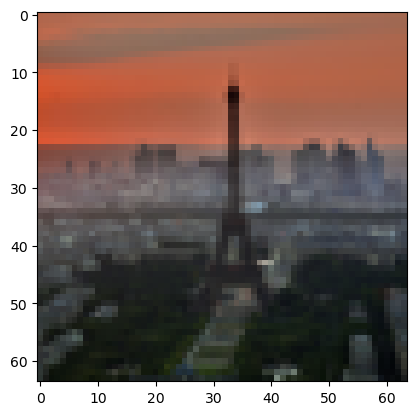

y = 0.0, and your algorithm predicts it as "cat"


In [229]:
myimage = "./images/towerimage.jpg"

# We preprocess the image to fit your algorithm.
image = np.array(Image.open(myimage).resize((num_px, num_px))) #converting image to an array after opening and resizing it
print(image.shape)
plt.imshow(image)
plt.show()

#normalize
image = image / 255

#reshape the image to a column vector using transpose
image = image.reshape(1, -1).T #1, image.shape[0] * image.shape[1] * image.shape[2]

#predict using our first model
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)
# print(classes[int(np.squeeze(my_predicted_image))])
print("y = 0.0" + ", and your algorithm predicts it as \"" + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\"")

#Observe that model is predicting this tower image as cat

(64, 64, 3)


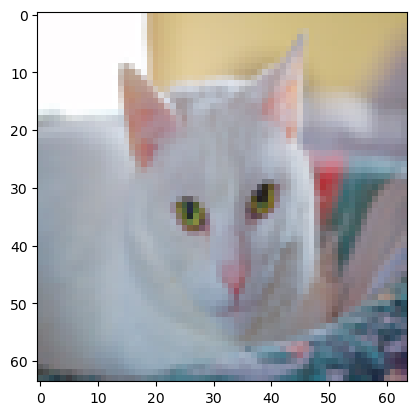

y = 1.0, and your algorithm predicts it as "cat"


In [230]:
myimage = "./images/catmyimage.jpg"

# We preprocess the image to fit your algorithm.
image = np.array(Image.open(myimage).resize((num_px, num_px))) #converting image to an array after opening and resizing it
print(image.shape)
plt.imshow(image)
plt.show()

#normalize
image = image / 255

#reshape the image to a column vector using transpose
image = image.reshape(1, -1).T #1, image.shape[0] * image.shape[1] * image.shape[2]

#predict using our first model
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)
# print(classes[int(np.squeeze(my_predicted_image))])
print("y = 1.0" + ", and your algorithm predicts it as \"" + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\"")

In [244]:
#take the existing non cat image from the training set and see whether the model is predicting right or not
print(test_set_x.shape)

noncat_idxs = test_set_y==0
print(noncat_idxs)

non_cat_test_x = test_set_x[:, noncat_idxs[0]]
print(non_cat_test_x.shape)

#predict our non cat images using our first model
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], non_cat_test_x)
print(my_predicted_image) 

(12288, 50)
[[False False False False False  True False False False False False False
  False  True  True False  True False False False False  True  True False
  False False False  True False  True False False False False  True  True
   True False  True  True False False False  True  True  True False False
  False  True]]
(12288, 17)
[[1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0]]


In [246]:
#show those images
for idx in range(non_cat_test_x.shape[1]):
    plt.imshow(non_cat_test_x[:, idx].reshape(num_px, num_px, 3))
    plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
#to save the image from a numpy array as an imge
# from PIL import Image
# im = Image.fromarray(arr)
# im.save("your_file.jpeg")

#### To understand, why the model is giving wrong prediction despite the meaningful test accuracy, check out the error analysis bookmark 
    https://community.deeplearning.ai/t/some-experiments-with-the-cat-recognition-assignment-c1w4a2/34124/3
    
#### What to remember from this assignment:

    - Preprocessing the dataset is important.
    
        - You implemented each function separately: 
            - initialize(), propagate(), optimize(). Then you built a model().
    
        - Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!
        
    Finally, if you'd like, we invite you to try different things on this Notebook. Things you can play with include: 
    - Play with the learning rate and the number of iterations 
    - Try different initialization methods and compare the results 
    - Test other preprocessings (center the data, or divide each row by its standard deviation)

###### Bibliography:

    http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
    https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c

In [247]:
#Self practice
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py

In [263]:
def load_data():
    train_set = h5py.File("./data/train_catvnoncat.h5", "r")
    test_set = h5py.File("./data/test_catvnoncat.h5", "r")
    train_set_x_orig = train_set["train_set_x"][:]
    train_set_y_orig = train_set["train_set_y"][:]
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))

    test_set_x_orig = test_set["test_set_x"][:]
    test_set_y_orig = test_set["test_set_y"][:]
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    classes = np.array(test_set["list_classes"][:])
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y = load_data()

In [264]:
print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)
print(classes)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
[b'non-cat' b'cat']


In [440]:
def preprocess_input_data(X_train, X_test):
    #reshape or flatten
    X_train = X_train.reshape((X_train.shape[0], -1)).T
    X_test = X_test.reshape((X_test.shape[0], -1)).T
    #standardization
    X_train = X_train / 255
    X_test = X_test / 255
    return X_train, X_test

def initialize_params(dim):
    W = np.zeros((dim, 1))
    b = 0.0
    return W, b

def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

def propagate(X, y, W, b): 
    n, m = X.shape
    Z = np.dot(W.T, X) + b
    A = sigmoid(Z)
    J = -(np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))) / m
#     J = np.squeeze(np.array(J))
    dJ_dW = (np.dot(X, (A - y).T)) / m
    dJ_db = (np.sum(A - y)) / m
    grads = {"dJ_dW": dJ_dW, "dJ_db": dJ_db}
    return J, grads

def optimize(X, y, W, b, num_iters=1000, learning_rate=0.0001, print_train=False):
    W = copy.deepcopy(W)
    b = copy.deepcopy(b)
    costs = []
    for i in range(num_iters):
        #forward propagation
        cost, grads = propagate(X, y, W, b)
        #Backward propagation 
        dJ_dW = grads["dJ_dW"]
        dJ_db = grads["dJ_db"]
        W = W - learning_rate * dJ_dW
        b = b - learning_rate * dJ_db
        if i % 100 == 0:
            costs.append(cost) 
            if print_train:
                print(f"Iteration {i},  cost: {cost}")
    params = {"W": W, "b": b} #Takes the lastly updated w and b
    grads = {"dJ_dW": dJ_dW, "dJ_db": dJ_db}
    return params, costs, grads

def predict(X, W, b):
    n, m = X.shape
    Y_prediction = np.zeros((1, m))
    y_pred = sigmoid(np.dot(W.T, X) + b) #(1, m)
    for i in range(m):
        if y_pred[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    return Y_prediction
    
def model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iters=1000, learning_rate=0.05, print_train=False):
    #preprocessing
    X_train, X_test = preprocess_input_data(train_set_x_orig, test_set_x_orig)
    n, m = X_train.shape

    assert X_train.shape[1] == train_set_y.shape[1] , "Check the X_train shape"
    assert X_test.shape[1] == test_set_y.shape[1] , "Check the X_test shape"
    
    #training
    W, b = initialize_params(n)
    assert W.shape == (X_train.shape[0], 1), "W shape doesnt match with X_train"
    params, costs, grads  = optimize(X_train, train_set_y, W, b, num_iters, learning_rate, print_train)
    
    #prediction
    W = params["W"].reshape(n, 1)
    b = params["b"]
    y_train_preds = predict(X_train, W, b)
    y_test_preds = predict(X_test, W, b)
    
    if print_train:
        print(f"Training accuracy: {100 - np.mean(np.abs(y_train_preds - train_set_y)) * 100}") 
        #The formula used is (1 - mean_absolute_error) * 100 to convert the mean absolute error into a percentage accuracy.
        print(f"Test accuracy: {100 - np.mean(np.abs(y_test_preds - test_set_y)) * 100}")
 
    history = {
        "costs": costs,
        "params" : params,
        "grads" : grads,
        "learning_rate": learning_rate,
        "y_train_preds" : y_train_preds,
        "y_test_preds" : y_test_preds
    }
    return history

In [347]:
history = model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iters=2000, learning_rate=0.005, print_train=True)

Iteration 0,  cost: 0.6931471805599453
Iteration 100,  cost: 0.5845083636993086
Iteration 200,  cost: 0.46694904094655476
Iteration 300,  cost: 0.3760068669480209
Iteration 400,  cost: 0.33146328932825125
Iteration 500,  cost: 0.303273067474383
Iteration 600,  cost: 0.27987958658260487
Iteration 700,  cost: 0.2600421369258757
Iteration 800,  cost: 0.2429406846779662
Iteration 900,  cost: 0.2280042225672607
Iteration 1000,  cost: 0.21481951378449643
Iteration 1100,  cost: 0.20307819060644985
Iteration 1200,  cost: 0.19254427716706862
Iteration 1300,  cost: 0.18303333796883509
Iteration 1400,  cost: 0.17439859438448874
Iteration 1500,  cost: 0.1665213970540033
Iteration 1600,  cost: 0.15930451829756614
Iteration 1700,  cost: 0.15266732471296504
Iteration 1800,  cost: 0.14654223503982336
Iteration 1900,  cost: 0.1408720757031016
Training accuracy: 99.04306220095694
Test accuracy: 70.0


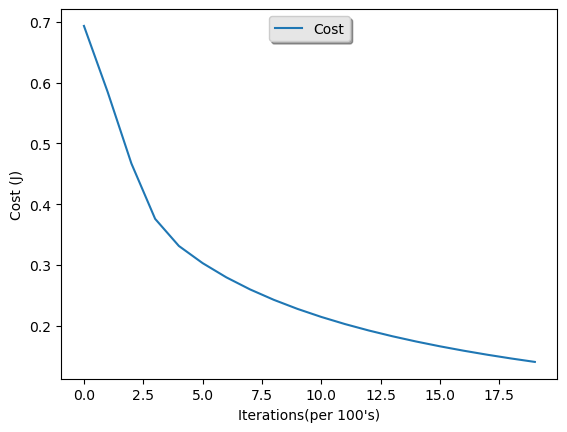

In [349]:
#plotting the learning curve cost vs iterations
plt.plot(history["costs"], label=f"Cost")
plt.xlabel("Iterations(per 100's)")
plt.ylabel("Cost (J)")
legend = plt.legend(loc="upper center", shadow=True)
frame = legend.get_frame()
frame.set_facecolor("0.9")
plt.show()

(209, 64, 64, 3)


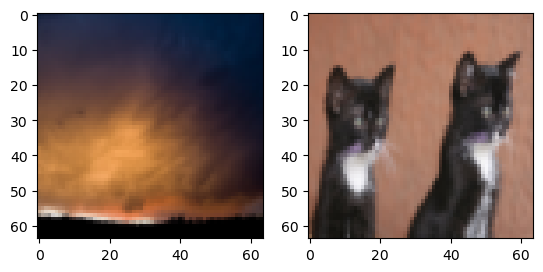

In [357]:
#visualizing the first image using plt.imshow()
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_set_x_orig[0])
ax[1].imshow(test_set_x_orig[0])
plt.show()

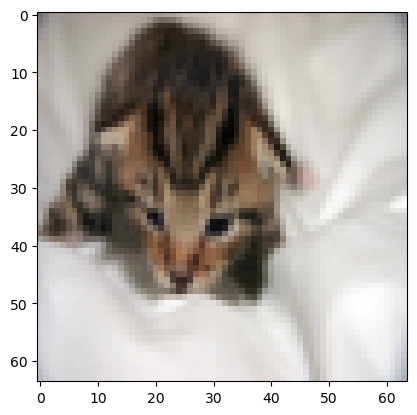

y = 1, and your model predicted it as cat


In [412]:
#visualizing the first image using plt.imshow() from the test set and the model prediction
idx = 1 #second image
num_px = 64
plt.imshow(test_set_x[:, idx].reshape(num_px, num_px, 3))
plt.show()
print("y = " + str(np.squeeze(test_set_y[:, idx])) + ", and your model predicted it as " + classes[int(np.squeeze(history["y_test_preds"][:, idx]))].decode("utf-8"))

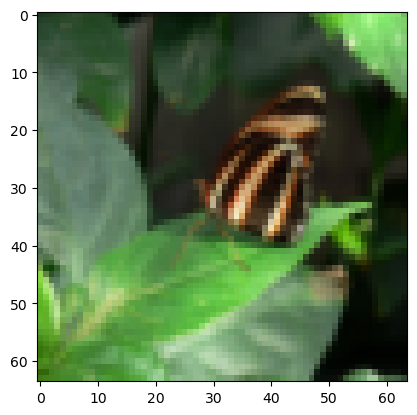

y = 0, and your model predicted it as cat


In [421]:
#wrong classification
idx = 5 
num_px = 64
plt.imshow(test_set_x[:, idx].reshape(num_px, num_px, 3))
plt.show()
print("y = " + str(np.squeeze(test_set_y[:, idx])) + ", and your model predicted it as " + classes[int(np.squeeze(history["y_test_preds"][:, idx]))].decode("utf-8"))

In [376]:
#Checking the proportions of classes in test and train set
print("Train set proportion of \"Cat\" class: {:.0f} %".format((sum(train_set_y[0]) / len(train_set_y[0])) * 100 ))
print("Train set proportion of \"Non Cat\" class: {:.0f} %".format((1 - sum(train_set_y[0]) / len(train_set_y[0])) * 100))

print("Test set proportion of \"Cat\" class: {:.0f} %".format((sum(test_set_y[0]) / len(test_set_y[0])) * 100 ))
print("Test set proportion of \"Non Cat\" class: {:.0f} %".format((1 - sum(test_set_y[0]) / len(test_set_y[0])) * 100))

Train set proportion of "Cat" class: 34 %
Train set proportion of "Non Cat" class: 66 %
Test set proportion of "Cat" class: 66 %
Test set proportion of "Non Cat" class: 34 %


Model predicted the tower image as "cat"


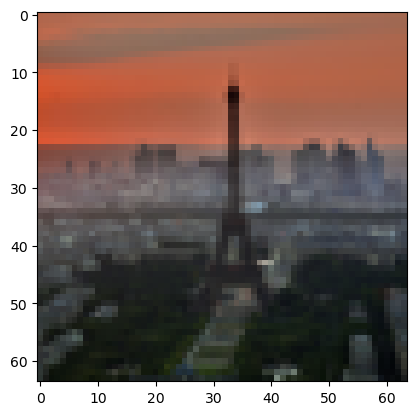

In [423]:
#prediction of our own image
num_px = 64
img = Image.open("./images/towerimage.jpg").resize((num_px, num_px))
img_arr = np.array(img)
img_arr = img_arr.reshape(1, -1).T
img_arr = img_arr / 255
W, b = history["params"]["W"], history["params"]["b"]
prediction = predict(img_arr, W, b)
print("Model predicted the tower image as \"" + classes[int(np.squeeze(prediction))].decode("utf-8") + "\"")
plt.imshow(img)
plt.show()

# img = Image.open("./images/towerimage.jpg")
# image = np.array(ndimage.imread(img, flatten=False))
# image = image/255.
# my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
# W, b = history["params"]["W"], history["params"]["b"]
# my_predicted_image = predict(img_arr, W, b)
# plt.imshow(image)
# print("Model predicted the tower image as \"" + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\"")

    Observation:
        Observe how model is predicting everything as cat.

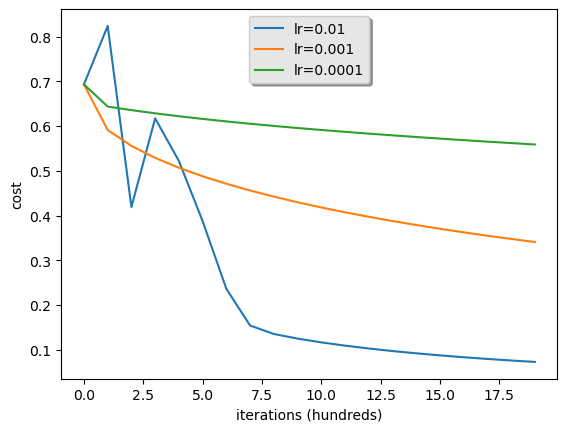

In [419]:
#learning rate tuning
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for lr in learning_rates:
    models[str(lr)] = model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iters=2000, learning_rate=lr, print_train=False)
    
for lr in learning_rates:
    plt.plot(models[str(lr)]["costs"], label=f"lr={lr}")

legend = plt.legend(loc="upper center", shadow=True)
frame = legend.get_frame()
frame.set_facecolor("0.9")
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
plt.show()

In [441]:
#increase the iterations with the usual model
history = model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iters=5000, learning_rate=0.005, print_train=True)

Iteration 0,  cost: 0.6931471805599453
Iteration 100,  cost: 0.5845083636993086
Iteration 200,  cost: 0.46694904094655476
Iteration 300,  cost: 0.3760068669480209
Iteration 400,  cost: 0.33146328932825125
Iteration 500,  cost: 0.303273067474383
Iteration 600,  cost: 0.27987958658260487
Iteration 700,  cost: 0.2600421369258757
Iteration 800,  cost: 0.2429406846779662
Iteration 900,  cost: 0.2280042225672607
Iteration 1000,  cost: 0.21481951378449643
Iteration 1100,  cost: 0.20307819060644985
Iteration 1200,  cost: 0.19254427716706862
Iteration 1300,  cost: 0.18303333796883509
Iteration 1400,  cost: 0.17439859438448874
Iteration 1500,  cost: 0.1665213970540033
Iteration 1600,  cost: 0.15930451829756614
Iteration 1700,  cost: 0.15266732471296504
Iteration 1800,  cost: 0.14654223503982336
Iteration 1900,  cost: 0.1408720757031016
Iteration 2000,  cost: 0.1356080752591202
Iteration 2100,  cost: 0.1307083213047731
Iteration 2200,  cost: 0.12613655733642845
Iteration 2300,  cost: 0.1218612331

  CLearly overfits the training data and no increase in the performance of test data

In [447]:
#random intialization of w and b to 0.0
def preprocess_input_data(X_train, X_test):
    #reshape or flatten
    X_train = X_train.reshape((X_train.shape[0], -1)).T
    X_test = X_test.reshape((X_test.shape[0], -1)).T
    #standardization
    X_train = X_train / 255
    X_test = X_test / 255
    return X_train, X_test

def initialize_params(dim):
    #random initialization
#     W = np.zeros((dim, 1))
#     b = 0.0
    np.random.seed(42)
    W = np.random.randn(dim, 1) #Return a sample (or samples) from the "standard normal" distribution.
    print(W.shape)
    b = np.random.randn()
    return W, b

def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

def propagate(X, y, W, b): 
    n, m = X.shape
    Z = np.dot(W.T, X) + b
    A = sigmoid(Z)
    J = -(np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))) / m
#     J = np.squeeze(np.array(J))
    dJ_dW = (np.dot(X, (A - y).T)) / m
    dJ_db = (np.sum(A - y)) / m
    grads = {"dJ_dW": dJ_dW, "dJ_db": dJ_db}
    return J, grads

def optimize(X, y, W, b, num_iters=1000, learning_rate=0.0001, print_train=False):
    W = copy.deepcopy(W)
    b = copy.deepcopy(b)
    costs = []
    for i in range(num_iters):
        #forward propagation
        cost, grads = propagate(X, y, W, b)
        #Backward propagation 
        dJ_dW = grads["dJ_dW"]
        dJ_db = grads["dJ_db"]
        W = W - learning_rate * dJ_dW
        b = b - learning_rate * dJ_db
        if i % 100 == 0:
            costs.append(cost) 
            if print_train:
                print(f"Iteration {i},  cost: {cost}")
    params = {"W": W, "b": b} #Takes the lastly updated w and b
    grads = {"dJ_dW": dJ_dW, "dJ_db": dJ_db}
    return params, costs, grads

def predict(X, W, b):
    n, m = X.shape
    Y_prediction = np.zeros((1, m))
    y_pred = sigmoid(np.dot(W.T, X) + b) #(1, m)
    for i in range(m):
        if y_pred[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    return Y_prediction
    
def model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iters=1000, learning_rate=0.05, print_train=False):
    #preprocessing
    X_train, X_test = preprocess_input_data(train_set_x_orig, test_set_x_orig)
    n, m = X_train.shape

    assert X_train.shape[1] == train_set_y.shape[1] , "Check the X_train shape"
    assert X_test.shape[1] == test_set_y.shape[1] , "Check the X_test shape"
    
    #training
    W, b = initialize_params(n)
    assert W.shape == (X_train.shape[0], 1), "W shape doesnt match with X_train"
    params, costs, grads  = optimize(X_train, train_set_y, W, b, num_iters, learning_rate, print_train)
    
    #prediction
    W = params["W"].reshape(n, 1)
    b = params["b"]
    y_train_preds = predict(X_train, W, b)
    y_test_preds = predict(X_test, W, b)
    
    if print_train:
        print(f"Training accuracy: {100 - np.mean(np.abs(y_train_preds - train_set_y)) * 100}") 
        #The formula used is (1 - mean_absolute_error) * 100 to convert the mean absolute error into a percentage accuracy.
        print(f"Test accuracy: {100 - np.mean(np.abs(y_test_preds - test_set_y)) * 100}")
 
    history = {
        "costs": costs,
        "params" : params,
        "grads" : grads,
        "learning_rate": learning_rate,
        "y_train_preds" : y_train_preds,
        "y_test_preds" : y_test_preds
    }
    return history

history = model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iters=2000, learning_rate=0.005, print_train=True)

(12288, 1)
Iteration 0,  cost: nan
Iteration 100,  cost: nan


C:\Users\malla\AppData\Local\Temp\ipykernel_30820\1705369252.py:29: RuntimeWarning: divide by zero encountered in log
  J = -(np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))) / m
C:\Users\malla\AppData\Local\Temp\ipykernel_30820\1705369252.py:29: RuntimeWarning: invalid value encountered in multiply
  J = -(np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))) / m


Iteration 200,  cost: nan
Iteration 300,  cost: nan
Iteration 400,  cost: nan
Iteration 500,  cost: nan
Iteration 600,  cost: nan
Iteration 700,  cost: nan
Iteration 800,  cost: nan
Iteration 900,  cost: nan
Iteration 1000,  cost: nan
Iteration 1100,  cost: nan
Iteration 1200,  cost: nan
Iteration 1300,  cost: nan
Iteration 1400,  cost: nan
Iteration 1500,  cost: nan
Iteration 1600,  cost: nan
Iteration 1700,  cost: nan
Iteration 1800,  cost: nan
Iteration 1900,  cost: nan
Training accuracy: 77.51196172248804
Test accuracy: 62.0


    Observe how all the costs are nan. This is because the sigmoid denominator is having a very big number and leading to small number as activation result, and ultilately log in the log in the cost is giving inf

##### Different Initializations of w and b
    In logistic regression, the parameters w and b need to be initialized before training the model. Proper initialization can help the model converge faster and achieve better results. Here are some common initialization methods for the parameters w and b in logistic regression:

**Zero Initialization:**
- Initialize both w and b to zero. While this is simple, it might not be the best choice as it can lead to symmetry breaking issues, where all hidden units in the network learn the same features and gradients become symmetric. This will be explained in further weeks

**Random Initialization:**
- Initialize w with small random values and b to zero. This helps to break symmetry. It's common to use small random numbers (e.g., drawn from a normal distribution with mean 0 and small variance) to avoid very large initial weights that could slow down learning.

**Xavier/Glorot Initialization:**
- This method initializes w with random values drawn from a distribution with zero mean and a variance of 1 / n_in, where n_in is the number of input units in the weight matrix. This method takes into account the size of the input layer and aims to provide a reasonable scale for the initial weights.

**He Initialization:**
- Similar to Xavier initialization, but it uses a variance of 2 / n_in, which is more appropriate for the Rectified Linear Unit (ReLU) activation function.

**LeCun Initialization:**
 - This is a variant of Xavier initialization that takes into account the activation function's slope at the initial point. It initializes w with random values drawn from a distribution with zero mean and a variance of 1 / n_in where n_in is the number of input units.

    
  Here's an example of how you might use Xavier initialization for logistic regression parameters w and b using NumPy:


    import numpy as np

    def initialize_parameters(n_features):
        np.random.seed(42)
        w = np.random.randn(n_features) * np.sqrt(1.0 / n_features)
        b = 0.0  # Initialize bias to zero
        return w, b

    n_features = 10  # Number of features in your dataset
    w, b = initialize_parameters(n_features)
    print("Initialized w:", w)
    print("Initialized b:", b)

In [439]:
#Standard scaling
from sklearn.preprocessing import StandardScaler
def preprocess_input_data(X_train, X_test):
    #reshape or flatten
    X_train = X_train.reshape((X_train.shape[0], -1)).T
    X_test = X_test.reshape((X_test.shape[0], -1)).T
#     X_train = X_train / 255
#     X_test = X_test / 255
    scalar = StandardScaler()
    X_train = scalar.fit_transform(X_train.T)
    X_test = scalar.transform(X_test.T)
    X_train = X_train.T
    X_test = X_test.T
    print(X_train.shape)
    print(X_test.shape)
    return X_train, X_test

def initialize_params(dim):
    W = np.zeros((dim, 1))
    b = 0.0
    return W, b

def sigmoid(z):
    if np.allclose(z, [0]): print("yes")
    
    s = 1 / (1 + np.exp(-z))
    return s

def propagate(X, y, W, b): 
    n, m = X.shape
    Z = np.dot(W.T, X) + b
    A = sigmoid(Z)
    J = -(np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))) / m
#     J = np.squeeze(np.array(J))
    dJ_dW = (np.dot(X, (A - y).T)) / m
    dJ_db = (np.sum(A - y)) / m
    grads = {"dJ_dW": dJ_dW, "dJ_db": dJ_db}
    return J, grads

def optimize(X, y, W, b, num_iters=1000, learning_rate=0.0001, print_train=False):
    W = copy.deepcopy(W)
    b = copy.deepcopy(b)
    costs = []
    for i in range(num_iters):
        #forward propagation
        cost, grads = propagate(X, y, W, b)
        #Backward propagation 
        dJ_dW = grads["dJ_dW"]
        dJ_db = grads["dJ_db"]
        W = W - learning_rate * dJ_dW
        b = b - learning_rate * dJ_db
        if i % 100 == 0:
            costs.append(cost) 
            if print_train:
                print(f"Iteration {i},  cost: {cost}")
    params = {"W": W, "b": b} #Takes the lastly updated w and b
    grads = {"dJ_dW": dJ_dW, "dJ_db": dJ_db}
    return params, costs, grads

def predict(X, W, b):
    n, m = X.shape
    Y_prediction = np.zeros((1, m))
    y_pred = sigmoid(np.dot(W.T, X) + b) #(1, m)
    for i in range(m):
        if y_pred[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    return Y_prediction
    
def model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iters=1000, learning_rate=0.05, print_train=False):
    #preprocessing
    X_train, X_test = preprocess_input_data(train_set_x_orig, test_set_x_orig)
    n, m = X_train.shape

    assert X_train.shape[1] == train_set_y.shape[1] , "Check the X_train shape"
    assert X_test.shape[1] == test_set_y.shape[1] , "Check the X_test shape"
    
    #training
    W, b = initialize_params(n)
    assert W.shape == (X_train.shape[0], 1), "W shape doesnt match with X_train"
    params, costs, grads  = optimize(X_train, train_set_y, W, b, num_iters, learning_rate, print_train)
    
    #prediction
    W = params["W"].reshape(n, 1)
    b = params["b"]
    y_train_preds = predict(X_train, W, b)
    y_test_preds = predict(X_test, W, b)
    
    if print_train:
        print(f"Training accuracy: {100 - np.mean(np.abs(y_train_preds - train_set_y)) * 100}") 
        #The formula used is (1 - mean_absolute_error) * 100 to convert the mean absolute error into a percentage accuracy.
        print(f"Test accuracy: {100 - np.mean(np.abs(y_test_preds - test_set_y)) * 100}")
 
    history = {
        "costs": costs,
        "params" : params,
        "grads" : grads,
        "learning_rate": learning_rate,
        "y_train_preds" : y_train_preds,
        "y_test_preds" : y_test_preds
    }
    return history

history = model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iters=2000, learning_rate=0.005, print_train=True)

(12288, 209)
(12288, 50)
yes
Iteration 0,  cost: 0.6931471805599453
Iteration 100,  cost: 0.21530980239570294
Iteration 200,  cost: 0.13601455583488245
Iteration 300,  cost: 0.09910802280729834
Iteration 400,  cost: 0.07744426335358646
Iteration 500,  cost: 0.06326495617833265
Iteration 600,  cost: 0.05331060943555779
Iteration 700,  cost: 0.045968095104733396
Iteration 800,  cost: 0.040346711137311565
Iteration 900,  cost: 0.035915282480499876
Iteration 1000,  cost: 0.032338331114504765
Iteration 1100,  cost: 0.029394206532456644
Iteration 1200,  cost: 0.026930975366837383
Iteration 1300,  cost: 0.024841234528609847
Iteration 1400,  cost: 0.023047040699130588
Iteration 1500,  cost: 0.02149053405353848
Iteration 1600,  cost: 0.020127906979678235
Iteration 1700,  cost: 0.01892541055307229
Iteration 1800,  cost: 0.0178566422167362
Iteration 1900,  cost: 0.016900661674542305
Training accuracy: 100.0
Test accuracy: 66.0


    Observation:
    Clearly overfits with standard scaling

In [448]:
#UNIT TESTS WITH TEST CASES
import numpy as np
   
def sigmoid_test(target):
    x = np.array([0, 2])
    output = target(x)
    assert type(output) == np.ndarray, "Wrong type. Expected np.ndarray"
    assert np.allclose(output, [0.5, 0.88079708]), f"Wrong value. {output} != [0.5, 0.88079708]"
    output = target(1)
    assert np.allclose(output, 0.7310585), f"Wrong value. {output} != 0.7310585"
    print('\033[92mAll tests passed!')
            
def initialize_with_zeros_test_1(target):
    dim = 3
    w, b = target(dim)
    assert type(b) == float, f"Wrong type for b. {type(b)} != float"
    assert b == 0., "b must be 0.0"
    assert type(w) == np.ndarray, f"Wrong type for w. {type(w)} != np.ndarray"
    assert w.shape == (dim, 1), f"Wrong shape for w. {w.shape} != {(dim, 1)}"
    assert np.allclose(w, [[0.], [0.], [0.]]), f"Wrong values for w. {w} != {[[0.], [0.], [0.]]}"
    print('\033[92mFirst test passed!')
    
def initialize_with_zeros_test_2(target):
    dim = 4
    w, b = target(dim)
    assert type(b) == float, f"Wrong type for b. {type(b)} != float"
    assert b == 0., "b must be 0.0"
    assert type(w) == np.ndarray, f"Wrong type for w. {type(w)} != np.ndarray"
    assert w.shape == (dim, 1), f"Wrong shape for w. {w.shape} != {(dim, 1)}"
    assert np.allclose(w, [[0.], [0.], [0.], [0.]]), f"Wrong values for w. {w} != {[[0.], [0.], [0.], [0.]]}"
    print('\033[92mSecond test passed!')    

def propagate_test(target):
    w, b = np.array([[1.], [2.], [-1]]), 2.5, 
    X = np.array([[1., 2., -1., 0], [3., 4., -3.2, 1], [3., 4., -3.2, -3.5]])
    Y = np.array([[1, 1, 0, 0]])

    expected_dw = np.array([[-0.03909333], [ 0.12501464], [-0.99960809]])
    expected_db = np.float64(0.288106326429569)
    expected_grads = {'dw': expected_dw,
                      'db': expected_db}
    expected_cost = np.array(2.0424567983978403)
    expected_output = (expected_grads, expected_cost)
    
    grads, cost = target( w, b, X, Y)

    assert type(grads['dw']) == np.ndarray, f"Wrong type for grads['dw']. {type(grads['dw'])} != np.ndarray"
    assert grads['dw'].shape == w.shape, f"Wrong shape for grads['dw']. {grads['dw'].shape} != {w.shape}"
    assert np.allclose(grads['dw'], expected_dw), f"Wrong values for grads['dw']. {grads['dw']} != {expected_dw}"
    assert np.allclose(grads['db'], expected_db), f"Wrong values for grads['db']. {grads['db']} != {expected_db}"
    assert np.allclose(cost, expected_cost), f"Wrong values for cost. {cost} != {expected_cost}"
    print('\033[92mAll tests passed!')

def optimize_test(target):
    w, b, X, Y = np.array([[1.], [2.]]), 2., np.array([[1., 2., -1.], [3., 4., -3.2]]), np.array([[1, 0, 1]])
    expected_w = np.array([[-0.70916784], [-0.42390859]])
    expected_b = np.float64(2.26891346)
    expected_params = {"w": expected_w,
                       "b": expected_b}
   
    expected_dw = np.array([[0.06188603], [-0.01407361]])
    expected_db = np.float64(-0.04709353)
    expected_grads = {"dw": expected_dw,
                      "db": expected_db}
    
    expected_cost = [5.80154532, 0.31057104]
    expected_output = (expected_params, expected_grads, expected_cost)
    
    params, grads, costs = target(w, b, X, Y, num_iterations=101, learning_rate=0.1, print_cost=False)
    
    assert type(costs) == list, "Wrong type for costs. It must be a list"
    assert len(costs) == 2, f"Wrong length for costs. {len(costs)} != 2"
    assert np.allclose(costs, expected_cost), f"Wrong values for costs. {costs} != {expected_cost}"
    
    assert type(grads['dw']) == np.ndarray, f"Wrong type for grads['dw']. {type(grads['dw'])} != np.ndarray"
    assert grads['dw'].shape == w.shape, f"Wrong shape for grads['dw']. {grads['dw'].shape} != {w.shape}"
    assert np.allclose(grads['dw'], expected_dw), f"Wrong values for grads['dw']. {grads['dw']} != {expected_dw}"
    
    assert np.allclose(grads['db'], expected_db), f"Wrong values for grads['db']. {grads['db']} != {expected_db}"
    
    assert type(params['w']) == np.ndarray, f"Wrong type for params['w']. {type(params['w'])} != np.ndarray"
    assert params['w'].shape == w.shape, f"Wrong shape for params['w']. {params['w'].shape} != {w.shape}"
    assert np.allclose(params['w'], expected_w), f"Wrong values for params['w']. {params['w']} != {expected_w}"
    
    assert np.allclose(params['b'], expected_b), f"Wrong values for params['b']. {params['b']} != {expected_b}"

    
    print('\033[92mAll tests passed!')   
        
def predict_test(target):
    w = np.array([[0.3], [0.5], [-0.2]])
    b = -0.33333
    X = np.array([[1., -0.3, 1.5],[2, 0, 1], [0, -1.5, 2]])
    
    pred = target(w, b, X)
    
    assert type(pred) == np.ndarray, f"Wrong type for pred. {type(pred)} != np.ndarray"
    assert pred.shape == (1, X.shape[1]), f"Wrong shape for pred. {pred.shape} != {(1, X.shape[1])}"
    assert np.bitwise_not(np.allclose(pred, [[1., 1., 1]])), f"Perhaps you forget to add b in the calculation of A"
    assert np.allclose(pred, [[1., 0., 1]]), f"Wrong values for pred. {pred} != {[[1., 0., 1.]]}"
    
    print('\033[92mAll tests passed!')
    
def model_test(target):
    np.random.seed(0)
    
    expected_output = {'costs': [np.array(0.69314718)], 
                   'Y_prediction_test': np.array([[1., 1., 0.]]), 
                   'Y_prediction_train': np.array([[1., 1., 0., 1., 0., 0., 1.]]), 
                   'w': np.array([[ 0.08639757],
                           [-0.08231268],
                           [-0.11798927],
                           [ 0.12866053]]), 
                   'b': -0.03983236094816321}
    
    # Use 3 samples for training
    b, Y, X = 1.5, np.array([1, 0, 0, 1, 0, 0, 1]).reshape(1, 7), np.random.randn(4, 7),

    # Use 6 samples for testing
    x_test = np.random.randn(4, 3)
    y_test = np.array([0, 1, 0])

    d = target(X, Y, x_test, y_test, num_iterations=50, learning_rate=0.01)
    
    assert type(d['costs']) == list, f"Wrong type for d['costs']. {type(d['costs'])} != list"
    assert len(d['costs']) == 1, f"Wrong length for d['costs']. {len(d['costs'])} != 1"
    assert np.allclose(d['costs'], expected_output['costs']), f"Wrong values for d['costs']. {d['costs']} != {expected_output['costs']}"
    
    assert type(d['w']) == np.ndarray, f"Wrong type for d['w']. {type(d['w'])} != np.ndarray"
    assert d['w'].shape == (X.shape[0], 1), f"Wrong shape for d['w']. {d['w'].shape} != {(X.shape[0], 1)}"
    assert np.allclose(d['w'], expected_output['w']), f"Wrong values for d['w']. {d['w']} != {expected_output['w']}"
    
    assert np.allclose(d['b'], expected_output['b']), f"Wrong values for d['b']. {d['b']} != {expected_output['b']}"
    
    assert type(d['Y_prediction_test']) == np.ndarray, f"Wrong type for d['Y_prediction_test']. {type(d['Y_prediction_test'])} != np.ndarray"
    assert d['Y_prediction_test'].shape == (1, x_test.shape[1]), f"Wrong shape for d['Y_prediction_test']. {d['Y_prediction_test'].shape} != {(1, x_test.shape[1])}"
    assert np.allclose(d['Y_prediction_test'], expected_output['Y_prediction_test']), f"Wrong values for d['Y_prediction_test']. {d['Y_prediction_test']} != {expected_output['Y_prediction_test']}"
    
    assert type(d['Y_prediction_train']) == np.ndarray, f"Wrong type for d['Y_prediction_train']. {type(d['Y_prediction_train'])} != np.ndarray"
    assert d['Y_prediction_train'].shape == (1, X.shape[1]), f"Wrong shape for d['Y_prediction_train']. {d['Y_prediction_train'].shape} != {(1, X.shape[1])}"
    assert np.allclose(d['Y_prediction_train'], expected_output['Y_prediction_train']), f"Wrong values for d['Y_prediction_train']. {d['Y_prediction_train']} != {expected_output['Y_prediction_train']}"
    
    print('\033[92mAll tests passed!')
    

In [ ]:
sigmoid_test(sigmoid)
initialize_with_zeros_test_1(initialize_with_zeros)
initialize_with_zeros_test_2(initialize_with_zeros)
propagate_test(propagate)
optimize_test(optimize)
predict_test(predict)
model_test(model)

In [ ]:
https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/?ref=lbp

#### Bibliography:

http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c